# Comparing CC3 and CC2

Notebook to check how CC2 and CC3 models compare, because currently the results coming out look wrong.

In [1]:
cc2_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth"
cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth"
cc2_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/ckpt_0.000000_1000000.pt"

# must use config.diffusion_pointwise_hidden_l1 = 32
cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC3/ckpt_0.000000_6135000.pt"

# vanilla
#cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/Anatoliis_cc_2.pt"

from pointcloud.config_varients import caloclouds_3_simple_shower, caloclouds_2
from pointcloud.evaluation.bin_standard_metrics import get_caloclouds_models
from pointcloud.data.conditioning import normalise_cond_feats
from pointcloud.utils.metadata import Metadata

cc_2_configs = caloclouds_2.Configs()
cc_2_configs.dataset_path_in_storage = False
cc_2_configs.dataset_path = "/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
cc_2_configs.n_dataset_files = 10
cc_2_configs.distillation = True
cc_2_metadata = Metadata(cc_2_configs)
cc_2_metadata.vis_eng_rescale = 1.
cc_2_configs.metadata = cc_2_metadata

cc_models = get_caloclouds_models(cc2_diffusion_path, cc2_showerflow_path, caloclouds_names="CC2", configs=cc_2_configs)
cc_3_configs = caloclouds_3_simple_shower.Configs()
cc_3_configs.diffusion_pointwise_hidden_l1 = 32
cc_3_configs.distillation = True
cc_models.update(get_caloclouds_models(cc3_diffusion_path, cc3_showerflow_path, caloclouds_names="CC3", configs=cc_3_configs))
print(cc_models.keys())


/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/ckpt_0.000000_1000000.pt
original_nb4 has best loss -170.3614442786392
alt1_nb4 has best loss -162.38868557676977
alt1_nb4_wo[0, 1] has best loss -127.89362487792968
alt2_nb4 has best loss -128.3624267578125
alt2_nb4_wo[0, 1] has best loss -121.22644805908203
alt2_nb4_wo[0, 1, 2, 3, 4] has best loss -121.57145843505859
Found 62 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth
/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC3/ckpt_0.000000_6135000.pt
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth
dict_keys(['CC2', 'CC3'])


Now get some sample conditioning values with which to compare the models.
The same ones will be used for both models, however, the expected scaling may be different.


In [2]:
from pointcloud.data.conditioning import read_raw_regaxes_withcond
all_cond_configs = caloclouds_2.Configs()
all_cond_configs.dataset_path_in_storage = False
all_cond_configs.dataset_path = "/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
all_cond_configs.n_dataset_files = 10
all_cond_configs.cond_features_names = ["energy", "points", "p_norm_local"]
all_cond_configs.cond_features = 5
if True:
    cond, events = read_raw_regaxes_withcond(all_cond_configs, total_size=1_000, for_model=['diffusion'])
print(cond[:10])


Selecting evenly spaced events
tensor([[4.3710e+01, 2.8140e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.2829e+01, 9.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.7785e+01, 4.1160e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.4652e+01, 1.0870e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.9282e+01, 1.4110e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.2836e+01, 4.1840e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.5205e+01, 1.8940e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [5.7934e+01, 2.4680e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.3653e+01, 4.1410e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.8710e+01, 2.0940e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       dtype=torch.float64)


Make cond for both CC2 and CC3


In [3]:

all_cond_meta = Metadata(all_cond_configs)
original_cc2_max_points = 6_000
normalised_cond2 = cond.clone()
normalised_cond3 = cond.clone()
#normalised_cond[:, 3] = 0
#normalised_cond[:, 4] = 1
normalised_cond2[:, 0] /= all_cond_meta.incident_rescale
normalised_cond3[:, 0] /= 127
normalised_cond2[:, 1] = (normalised_cond2[:, 1]/original_cc2_max_points)*2 - 1
showerflow_cond = {"CC2": normalised_cond2[:, [0]], "CC3": normalised_cond3[:, [0, 2, 3, 4]]}
# for the diffusion models, the energy goes between -1 and 1
normalised_cond2[:, 0] = normalised_cond2[:, 0]*2 - 1
# for CC3, the energy is log scaled and standardised
Emean, Estd = -1.5300317, 1.2500798
normalised_cond3[:, 0] = ((normalised_cond3[:, 0]).log()-Emean)/Estd
diffusion_cond = {"CC2": normalised_cond2[:, [0, 1]], "CC3":normalised_cond3[:, [0, 2, 3, 4]]}

In [4]:
conditioned_samples = {}
point_per_event = 100
for name in cc_models:
    diffusion, flow_dist, configs = cc_models[name]
    d_cond = diffusion_cond[name].float()
    s_diffusion = diffusion.sample(d_cond, point_per_event, all_cond_configs)
    s_cond = showerflow_cond[name].float()
    s_showerflow = flow_dist.condition(s_cond).sample([len(s_cond)])
    conditioned_samples[name] = (s_diffusion, s_showerflow)

    

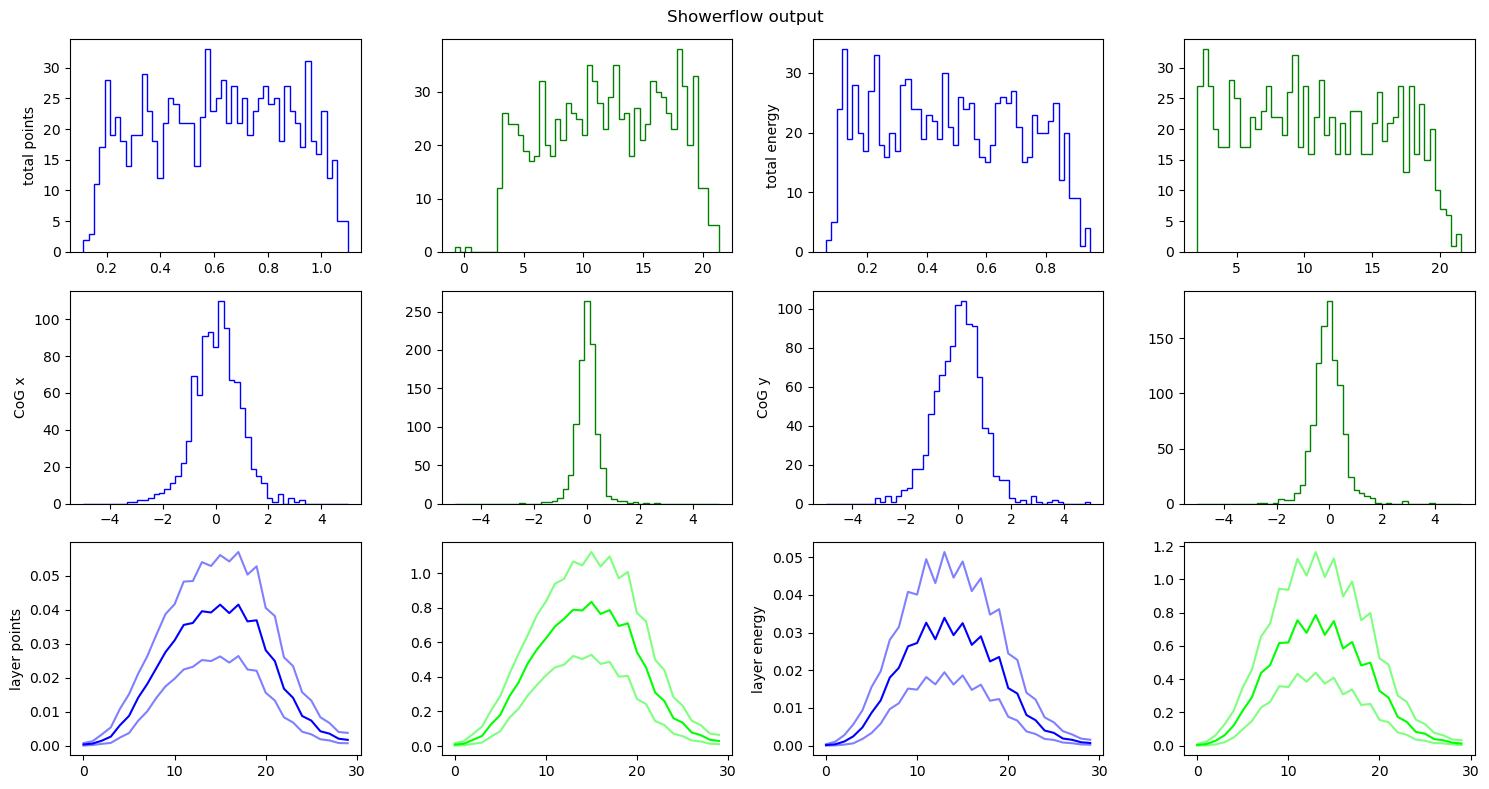

In [5]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax_arr = plt.subplots(3, 4, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))


i=4
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=6
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = conditioned_samples["CC2"][1][:, 0]
cc3_v = conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=8
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_pnts3[j], color=colour[j])



i=2
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=10
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

In [6]:
n_pnts = (events[..., -1] > 0).sum(axis=1)
energy = events[..., -1].sum(axis=1)/all_cond_meta.vis_eng_rescale
cog_x = ((events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[0])/all_cond_meta.std_cog[0]
cog_y = ((events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[1])/all_cond_meta.std_cog[1]
raw_cog_x = (events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)
raw_cog_y = (events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)



In [7]:

dataset_stats = np.load("/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/stats.npz")
for key in dataset_stats.keys():
    print(key, dataset_stats[key])

cc3_train_ds_meta = Metadata(caloclouds_3_simple_shower.Configs())
try:
    del all_cond_configs.metadata
except AttributeError:
    pass
cc_3_meta = Metadata(all_cond_configs)
# we need actual cog for this dataset
cc_3_meta.n_pts_rescale = cc3_train_ds_meta.n_pts_rescale

cc_3_meta.vis_eng_rescale = cc3_train_ds_meta.vis_eng_rescale/cc_3_meta.vis_eng_rescale
cc_3_meta.incident_rescale = 127

cc_3_meta.std_cog = 1./dataset_stats["std_cog"][[2,0,1]]
cc_3_meta.mean_cog[[0, 1]] = [0, 0]
cc_3_meta.log_incident_mean = cc3_train_ds_meta.log_incident_mean
cc_3_meta.log_incident_std = cc3_train_ds_meta.log_incident_std

cc_3_meta.found_attrs += ["log_incident_mean", "log_incident_std"]
print(cc3_train_ds_meta.std_cog, cc_3_meta.std_cog)



path /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
mean_point [ 1.22085438e-04  5.46113000e-01 -1.43398707e-02  3.42128658e-04]
std_point [5.01166184e-03 1.03514488e+00 2.80895001e-02 6.88304610e-04]
mean_event [ 3.82163269e-01  1.70949404e+03 -4.48880056e+01  1.07096315e+00]
std_event [5.18406994e-01 8.18390107e+02 2.19667064e+01 8.19594157e-01]
mean_n_points 3130.29362
std_n_points 1231.3112889384615
mean_cog [ 3.8028497e-01  1.8952594e+03 -4.9972588e+01]
std_cog [ 0.5199222  12.771177    0.48483732]
[1.24559791 0.95357278 2.59475371] [2.0625474  1.9233648  0.07830132]


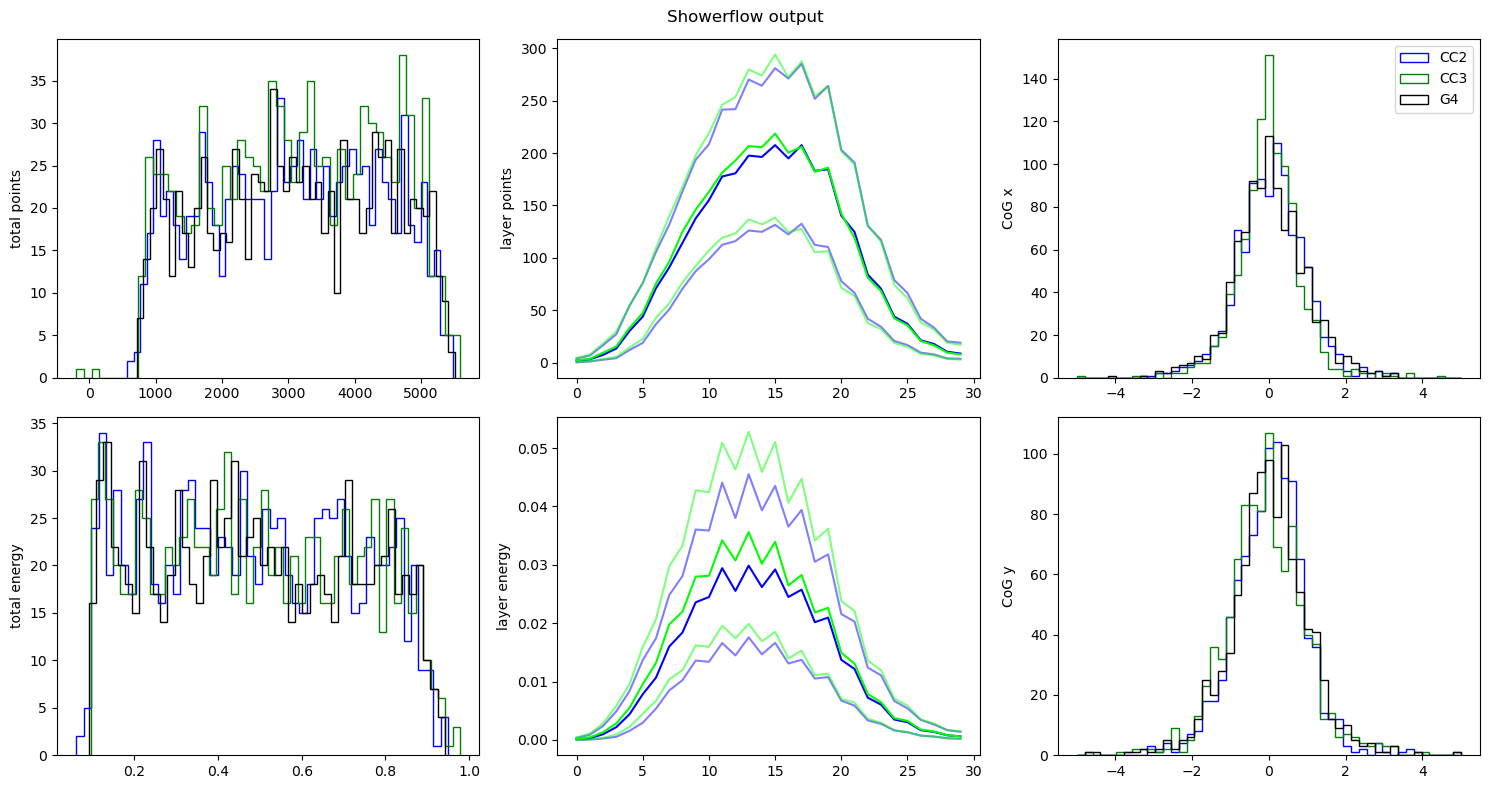

In [8]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))
histg4_settings = dict(label='G4', color='k', histtype='step', bins=np.linspace(-5, 5, 50))

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]#*all_cond_meta.std_cog[0]
cc3_v = conditioned_samples["CC3"][1][:, 0]*cc_3_meta.std_cog[0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]#*all_cond_meta.std_cog[1]
cc3_v = conditioned_samples["CC3"][1][:, 1]*cc_3_meta.std_cog[1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
histg4_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = (float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(cc_3_meta.n_pts_rescale/30)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(cc_3_meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

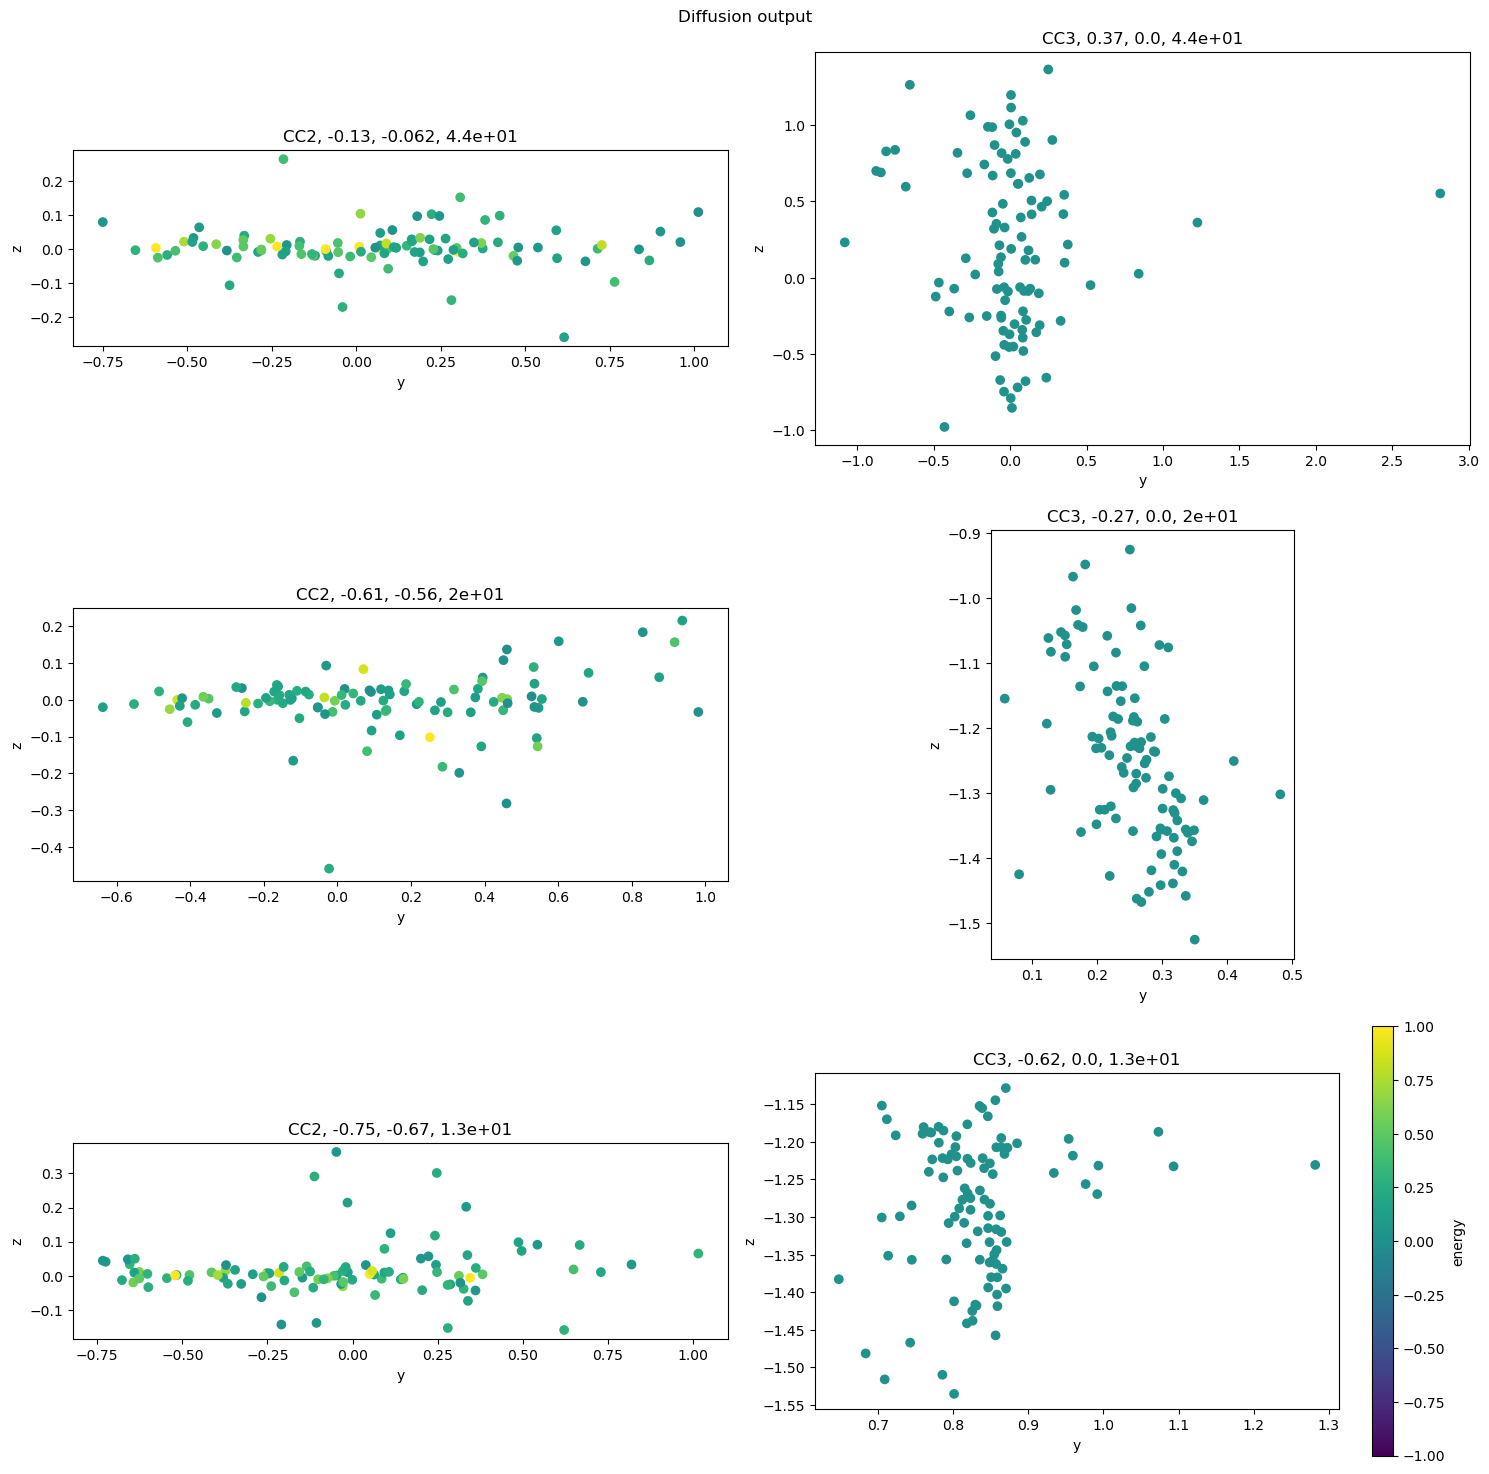

In [9]:
from matplotlib import pyplot as plt
min_energy = min(conditioned_samples["CC2"][0][..., -1].min(),
                 conditioned_samples["CC3"][0][..., -1].min())
max_energy = max(conditioned_samples["CC2"][0][..., -1].max(),
                 conditioned_samples["CC3"][0][..., -1].max())
min_energy = -1
max_energy = 1
use_events = [0, 51, 99]
fig, ax_arr = plt.subplots(len(use_events), 2, figsize=(15, len(use_events)*5))
fig.suptitle("Diffusion output")
for e, event in enumerate(use_events):
    for i, name in enumerate(conditioned_samples):
        s_diffusion, s_showerflow = conditioned_samples[name]
        s_diffusion = s_diffusion.detach()
        ax_arr[e, i].set_aspect(1)
        if "3" in name:
            energy_here = ((s_diffusion[event, :, 3]*Estd) + Emean).exp()
        else:
            energy_here = s_diffusion[event, :, 3]
        points = ax_arr[e, i].scatter(s_diffusion[event, :, 1], s_diffusion[event, :, 2], c=energy_here, vmin=min_energy, vmax=max_energy)
        ax_arr[e, i].set_title(f"{name}, {diffusion_cond[name][event, 0]:.2}, {diffusion_cond[name][event, 1]:.2}, {cond[event, 0]:.2}")
        ax_arr[e, i].set_xlabel("y")
        ax_arr[e, i].set_ylabel("z")
cbar = plt.colorbar(points)
cbar.set_label("energy")
plt.tight_layout()

In [11]:
from pointcloud.utils.showerflow_utils import truescale_showerflow_output
model_name = "CC2"
diffusion_m, sf_m, configs_m = cc_models[model_name]

import ipdb
if True:
    all_cond_meta = Metadata(all_cond_configs)
    if "3" in model_name:
        configs_m.metadata = cc_3_meta
    #ipdb.set_trace()
    np_ts, energy_ts, cog_x_ts, cog_y_ts, cog_z_ts, clusters_per_layer_ts, e_per_layer_ts = truescale_showerflow_output(conditioned_samples[model_name][1].clone(), configs_m)
    if np_ts is None:
        np_ts = clusters_per_layer_ts.sum(dim=1)
    if energy_ts is None:
        energy_ts = e_per_layer_ts.sum(dim=1)
print(np_ts.mean(), cog_x_ts.mean(), cog_y_ts.mean(), clusters_per_layer_ts.mean(), e_per_layer_ts.mean())
Metadata(configs_m)

tensor(3074.6780, dtype=torch.float64) tensor(-49.9491) tensor(0.4212) tensor(0.4181) tensor(0.3732)


Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047
 1976.70495605 1988.15002441 1993.375      2004.81994629 2010.04504395]
half_cell_size_global: 2.5441665649414062
cell_thickness_global: 0.5250244140625
half_cell_size_hdf5: 2.5441665649414062
cell_thickness_hdf5: 0.5250244140625
gun_xyz_pos_hdf5: [   0. 1811.  -50.]
orientation: hdf5:xyz==local:yzx
gun_xyz_pos_global: [   0.  1804.7  -50. ]
orientation_global: hdf5:xyz==global:xyz
layer_bottom_pos_global: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.405029

In [12]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC2
cond_m = {"showerflow":cond[:, [0]], "diffusion": cond[:, [0, 1]]}
diffusion_m, sf_m, configs_m = cc_models["CC2"]
all_cond_configs.device='cpu'
all_cond_configs.distillation = True
import ipdb
if True:
    import ipdb
    #ipdb.set_trace()
    cc2_events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=configs_m)

In [13]:
total_points_2s = (cc2_events[:, :, 3] > 0).sum(axis=1)
total_energy_2s = cc2_events[:, :, 3].sum(axis=1)/1000
cog_x_2s = ((cc2_events[..., -1]*cc2_events[..., 0]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[0])/all_cond_meta.std_cog[0]
cog_y_2s = ((cc2_events[..., -1]*cc2_events[..., 1]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[1])/all_cond_meta.std_cog[1]

In [15]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC3
max_cond = 1000000
cond_m = {"showerflow":cond[:max_cond, [0, 2, 3, 4]], "diffusion": cond[:max_cond, [0, 2, 3, 4]]}
diffusion_m, sf_m, configs_m = cc_models["CC3"]
configs_m.device='cpu'
configs_m.metadata = cc_3_meta
#cc_3_meta.std_cog = cc_3_meta.std_cog[[2,0,1]]
if True:
    #ipdb.set_trace()
    cc3_events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=configs_m)



In [16]:
dataset_stats = np.load("/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/stats.npz")
for key in dataset_stats.keys():
    print(key, dataset_stats[key])

path /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
mean_point [ 1.22085438e-04  5.46113000e-01 -1.43398707e-02  3.42128658e-04]
std_point [5.01166184e-03 1.03514488e+00 2.80895001e-02 6.88304610e-04]
mean_event [ 3.82163269e-01  1.70949404e+03 -4.48880056e+01  1.07096315e+00]
std_event [5.18406994e-01 8.18390107e+02 2.19667064e+01 8.19594157e-01]
mean_n_points 3130.29362
std_n_points 1231.3112889384615
mean_cog [ 3.8028497e-01  1.8952594e+03 -4.9972588e+01]
std_cog [ 0.5199222  12.771177    0.48483732]


In [17]:
total_points_3s = (cc3_events[:, :, 3] > 0).sum(axis=1)
total_energy_3s = cc3_events[:, :, 3].sum(axis=1)/1000
cog_x_3s_raw = (cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_x_3s = (cog_x_3s_raw-dataset_stats["mean_event"][0])/dataset_stats["std_event"][0]
cog_y_3s_raw = (cc3_events[..., -1]*cc3_events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_y_3s = (cog_y_3s_raw-dataset_stats["mean_event"][1])/dataset_stats["std_event"][1]
print(cog_x_3s_raw.mean(), cog_x_3s_raw.std(), cog_y_3s_raw.mean(), cog_y_3s_raw.std())
print(cog_x_3s.mean(), cog_x_3s.std(), cog_y_3s.mean(), cog_y_3s.std())

-0.009977312464616141 0.8217616158677908 -31.445876401659508 419.3679267145581
-0.7564338181506856 1.5851669172080485 -2.127273903219029 0.5124303475049552


In [18]:
total_points_3s = (cc3_events[:, :, 3] > 0).sum(axis=1)
total_energy_3s = cc3_events[:, :, 3].sum(axis=1)/1000
cog_x_3s = (cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)
#cog_x_3s = ((cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)-dataset_stats["mean_event"][0])/dataset_stats["std_event"][0]
cog_y_3s = (cc3_events[..., -1]*cc3_events[..., 1]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)
cog_z_3s = (cc3_events[..., -1]*cc3_events[..., 2]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)

#cog_y_3s = ((cc3_events[..., -1]*cc3_events[..., 1]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)-dataset_stats["mean_event"][1])/dataset_stats["std_event"][1]
print(cog_x_3s.mean(), cog_x_3s.std(), cog_y_3s.mean(), cog_y_3s.std(), cog_z_3s.mean(), cog_z_3s.std())

-0.009977312464616141 0.8217616158677908 -0.07228846938518108 1.049237465201988 1895.1191143186784 12.940667923337415


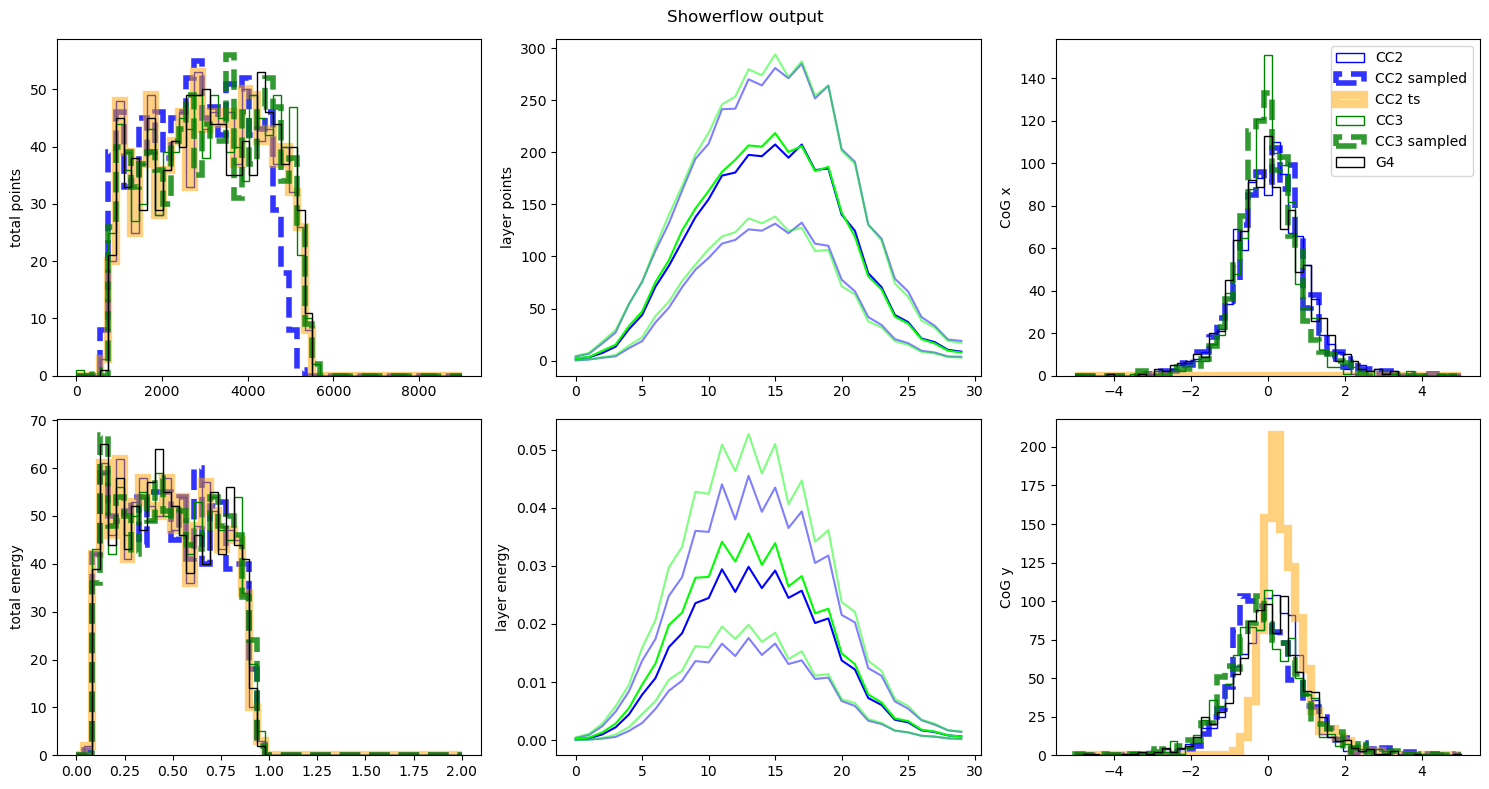

In [19]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist_common = dict(histtype='step', bins=np.linspace(-5, 5, 50))
hist2_settings = dict(label='CC2', color='blue')
hist2s_settings = dict(label='CC2 sampled', color='blue', linewidth=4, alpha=0.8, linestyle='--')
hist2ts_settings = dict(label=f'{model_name} ts', color='orange', linewidth=6, alpha=0.5)
hist3_settings = dict(label='CC3', color='green')
hist3s_settings = dict(label='CC3 sampled', color='green', linewidth=4, alpha=0.8, linestyle='--')
histg4_settings = dict(label='G4', color='k')
settings = [hist2_settings, hist2s_settings, hist2ts_settings, hist3_settings, hist3s_settings, histg4_settings]
for seti in settings:
    seti.update(hist_common)

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]*cc_3_meta.std_cog[0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_x_2s, **hist2s_settings)
ax_arr[i].hist(cog_x_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x_3s, **hist3s_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]*cc_3_meta.std_cog[1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_y_2s, **hist2s_settings)
ax_arr[i].hist(cog_y_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y_3s, **hist3s_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
for seti in settings:
    seti['bins'] = np.linspace(0, 9000, 50)
    
ax_arr[i].set_ylabel("total points")
cc2_v = (float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(cc_3_meta.n_pts_rescale)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_points_2s, **hist2s_settings)
ax_arr[i].hist(np_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(total_points_3s, **hist3s_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points") 
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(cc_3_meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
for seti in settings:
    seti['bins'] = np.linspace(0, 2, 50)
    
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_energy_2s, **hist2s_settings)
ax_arr[i].hist(energy_ts/1000, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(total_energy_3s, **hist3s_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(cc_3_meta.vis_eng_rescale*conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

In [20]:
for line_3, line_2 in zip(repr(cc_3_meta).split('\n'), repr(all_cond_meta).split('\n')):
    print(line_3 + '\t' + line_2)
    

Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5	Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5
layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293	layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707	 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488	 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629	 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047	 1938.14001465 1943.36499023 1954.81005859 1960.0350341